In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import keras
from keras.preprocessing.text import Tokenizer
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional,InputLayer
from sklearn.model_selection import train_test_split

In [35]:
import re

In [92]:
data_path  = "/content/preprocessed_data.csv"
df1 = pd.read_csv(data_path,names=['text','job_category'],encoding = "ISO-8859-1")
df2 = pd.read_csv('/content/data_scientist_united_states_job_postings_jobspikr.csv',names=['text','job_category'],encoding = "ISO-8859-1")
df3 = pd.read_csv('/content/software_developer_united_states_1971_20191023_1.csv',names=['text','job_category'],encoding = "ISO-8859-1")

In [52]:
df1

,text,job_category
0,an experienced hr professional hr mentor coach...,hr
1,head talent acquisition hr leader strategic pa...,hr
2,a talent acquisition hr professional experienc...,hr
3,over 18 years experience it ites bpo leading g...,hr
4,human resources business partner demonstrated ...,hr
...,...,...
665,experienced aircraft maintenance engineer demo...,aviation
666,aerobusiness professional independent consulta...,aviation
667,i ritu royborn india energeticambitious young ...,aviation
668,an mba graduate specialized aviation managemen...,aviation


In [53]:
df3

,text,job_category
0,The chosen Sr. Software Developer will be part...,software design
1,Position: C# Lead Software Developer Location:...,software design
2,"Senior Software Developer Hoboken, NJ Starts a...",software design
3,Position: C# Lead Software Developer Location:...,software design
4,RESPONSIBILITIES: Kforce has a client seeking ...,software design
...,...,...
3195,"Software Developer â?Asheville, NC\n\nPositio...",software design
3196,"Business Group Highlights\n\nCivilian, State a...",software design
3197,Job Description:\n\nThe candidate must be expe...,software design
3198,PLEASE ONLY APPLY IF YOU DO NOT NEED SPONSORSH...,software design


In [54]:
df2

,text,job_category
0,We have an immediate opening for a Sharp Data ...,data scientist
1,Candidates should have the following backgroun...,data scientist
2,We are seeking an extraordinary Data Scientist...,data scientist
3,Read what people are saying about working here...,data scientist
4,Read what people are saying about working here...,data scientist
...,...,...
6109,Join Upstart and help build the future of cred...,data scientist
6110,"Data Scientist, (Staff or Principal) at realto...",data scientist
6111,Job Summary: Would you like to play a part in ...,data scientist
6112,"Data Scientist, (Staff or Principal) at realto...",data scientist


In [93]:
df4=pd.concat([df2, df3], ignore_index = True,axis=0)

In [94]:
df=df4

In [95]:
d = {'job_category':df['job_category'].value_counts().index, 'count': df['job_category'].value_counts()}
df_cat = pd.DataFrame(data=d).reset_index(drop=True)
df_cat

,job_category,count
0,data scientist,6114
1,software design,3200


Text(0.5, 0, '类目')

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 31867 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 30446 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 20998 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 24067 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 31867 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 30446 missing from current font.
  font.set_te

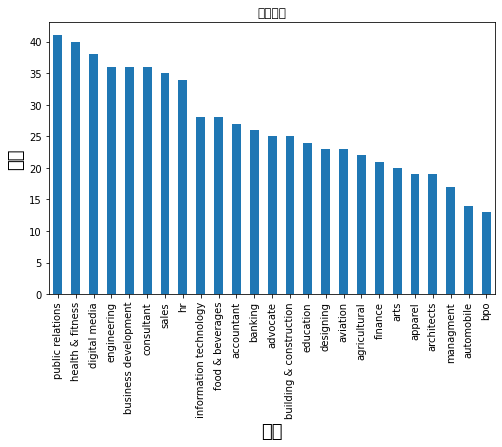

In [ ]:
df_cat.plot(x='job_category', y='count', kind='bar', legend=False,  figsize=(8, 5))
plt.title("类目分布")
plt.ylabel('数量', fontsize=18)
plt.xlabel('类目', fontsize=18)

In [33]:
def remove_punctuation(line):
    line = str(line)
    if line.strip()=='':
        return ''
    rule = re.compile(u"[^a-zA-Z0-9\u4E00-\u9FA5]")
    line = rule.sub('',line)
    return line


In [37]:
df1=df1.apply(remove_punctuation)
df2=df2.apply(remove_punctuation)
df3=df3.apply(remove_punctuation)

In [38]:
df2

job_discrib    0WehaveanimmediateopeningforaSharpData1Candida...
category       0datascientist1datascientist2datascientist3dat...
dtype: object

In [96]:
df['cat_id'] = df['job_category'].factorize()[0]
cat_id_df = df[['job_category', 'cat_id']].drop_duplicates().sort_values('cat_id').reset_index(drop=True)
cat_to_id = dict(cat_id_df.values)
id_to_cat = dict(cat_id_df[['cat_id', 'job_category']].values)
df.sample(10)

,text,job_category,cat_id
3134,Role: Data Scientist \n Location:&nbsp;Jackso...,data scientist,0
2732,AWS Data Scientist- San Francisco - $150K - We...,data scientist,0
9285,Job Title: Junior Software Engineer / Entry-Le...,software design,1
8588,The Challenge:\n\nAre you looking for an oppor...,software design,1
7278,THE OPPORTUNITY \nKleerMail is looking for a t...,software design,1
6477,"Minimum Required Skills: Python, JavaScript, A...",software design,1
1697,Job Description\n\nOur data scientists have a ...,data scientist,0
3087,Read what people are saying about working here...,data scientist,0
6558,Senior Software Developer Overview: Automate V...,software design,1
6553,Read what people are saying about working here...,software design,1


In [97]:
MAX_NB_WORDS = 500
# 每条cut_review最大的长度
MAX_SEQUENCE_LENGTH = 250
# 设置Embeddingceng层的维度
EMBEDDING_DIM = 100
 
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['text'].values)
word_index = tokenizer.word_index


In [98]:
from keras.preprocessing.sequence import pad_sequences

In [99]:
X = tokenizer.texts_to_sequences(df['text'].values)
#填充X,让X的各个列的长度统一
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
 
#多类标签的onehot展开
Y = pd.get_dummies(df['cat_id']).values
 
print(X.shape)
print(Y.shape)

(9314, 250)
(9314, 2)


In [100]:
#拆分训练集和测试集
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(8382, 250) (8382, 2)
(932, 250) (932, 2)


In [119]:
#定义模型
model = keras.models.Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(LSTM(100, dropout=0.2,return_sequences=True, recurrent_dropout=0.2))
model.add(LSTM(50, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(27, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 250, 100)          50000     
                                                                 
 lstm_9 (LSTM)               (None, 250, 100)          80400     
                                                                 
 lstm_10 (LSTM)              (None, 50)                30200     
                                                                 
 dense_5 (Dense)             (None, 27)                1377      
                                                                 
Total params: 161,977
Trainable params: 161,977
Non-trainable params: 0
_________________________________________________________________
None


In [112]:
epochs = 5
batch_size = 64

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1)

Epoch 1/5
118/118 [==============================] - 130s 1s/step - loss: 0.5344 - accuracy: 0.7738 - val_loss: 0.4531 - val_accuracy: 0.8069
Epoch 2/5
118/118 [==============================] - 126s 1s/step - loss: 0.4901 - accuracy: 0.7456 - val_loss: 0.5204 - val_accuracy: 0.6806
Epoch 3/5
118/118 [==============================] - 125s 1s/step - loss: 0.3266 - accuracy: 0.8304 - val_loss: 0.5860 - val_accuracy: 0.6806
Epoch 4/5
118/118 [==============================] - 126s 1s/step - loss: 0.3614 - accuracy: 0.8571 - val_loss: 0.2681 - val_accuracy: 0.9166
Epoch 5/5
118/118 [==============================] - 126s 1s/step - loss: 0.2645 - accuracy: 0.9128 - val_loss: 0.2470 - val_accuracy: 0.9201


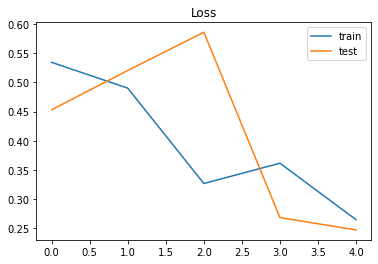

In [117]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

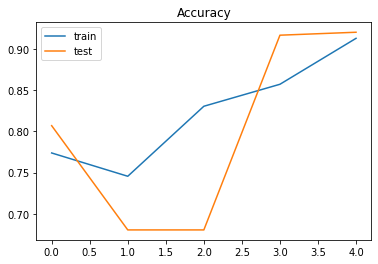

In [118]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();


In [105]:
def predict(text):
    seq = tokenizer.texts_to_sequences(text)
    padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
    pred = model.predict(padded)
    cat_id= pred.argmax(axis=1)[0]
    return cat_id_df[cat_id_df.cat_id==cat_id]['job_category'].values[0]


In [116]:
predict('data python All Experiences within an AWS/Big Data Environment')

'data scientist'